In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

## 5.1 A tidy forecasting workflow
Example - modelling GDP per capita over time.
![forecasting-workflow](../figures/forecasting-workflow.png)

### Data preparation (tidy)
The first step in forecasting is to prepare data in the correct format. This may include loading in data, identifying missing values, filtering the time series and other pre-processing tasks.

In [5]:
gdppc = (pd.read_csv('../data/tsibbledata/global_economy.csv')
        .assign(GDP_per_capita=lambda df: df['GDP']/df['Population'])
)

In [6]:
import plotnine as p9

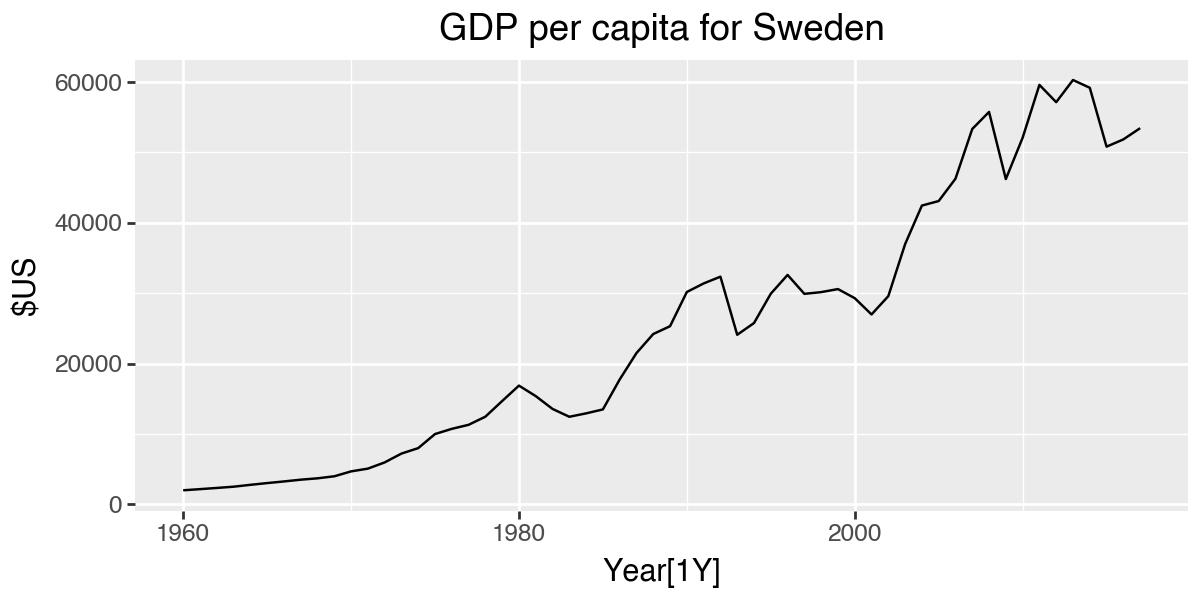

In [ ]:
p9.ggplot(gdppc.query("Country=='Sweden'")) \
    + p9.aes(x='Year', y='GDP_per_capita') \
    + p9.geom_line() \
    + p9.labs(x='Year[1Y]', y = "$US", title = "GDP per capita for Sweden") \
    + p9.theme(figure_size=(6, 3))

### Define a model (specify)
Specifying an appropriate model for the data is essential for producing appropriate forecasts. In this case let's use a linear trend model for GDP per capita. This can be specified in `statsmodels.formula.api` using `ols`.

In [10]:
from statsmodels.formula.api import ols

### Train the model (estimate)
Once an appropriate model is specified, we next train the model on some data. In this case we can use the syntax of `TSLM` in R's `fable` package.

In [ ]:
import sys
sys.path.append('..')
from utils import summarize
import numpy as np

In [45]:
models = (
    gdppc[~gdppc['GDP'].isna()]
    .groupby('Country')
    .pipe(summarize, lambda x: dict(
        trend_model = ols('GDP_per_capita ~ Year', x).fit()
        ))
)

### Check model performance (evaluate)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.0)

In [16]:
country = 'France'
economy = gdppc.query(f'Country == "{country}"')

In [17]:
country_model = models.trend_model[country]
pred = country_model.get_prediction(economy).summary_frame()

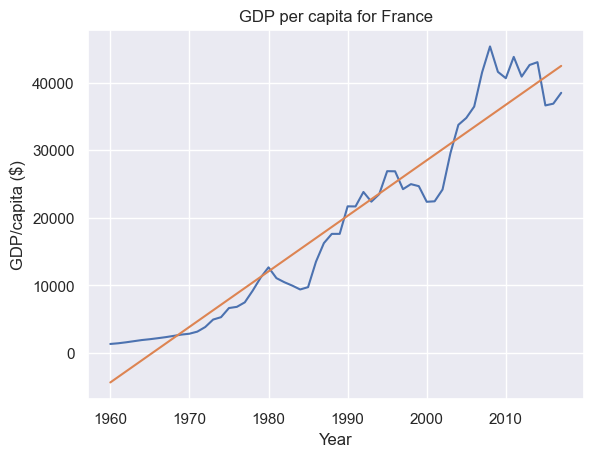

In [27]:
f, ax = plt.subplots()
ax.plot(economy['Year'], economy['GDP_per_capita'])
ax.plot(economy['Year'], pred['mean'])
ax.set(title=f'GDP per capita for {country}', xlabel='Year', ylabel='GDP/capita ($)')
plt.show()

### Produce forecasts (forecast) 

In [61]:
def get_predictions(models, country, years):
    country_model = models.trend_model[country]
    x = pd.DataFrame(dict(Year=years))
    pred95 = country_model.get_prediction(x).summary_frame()
    pred80 = country_model.get_prediction(x).summary_frame(alpha=0.2)
    return pred95, pred80

In [63]:
pred95, pred80 = get_predictions(models, country='Sweden', years=np.arange(2018, 2024))

In [62]:
economy = gdppc.query(f'Country == "{country}"')

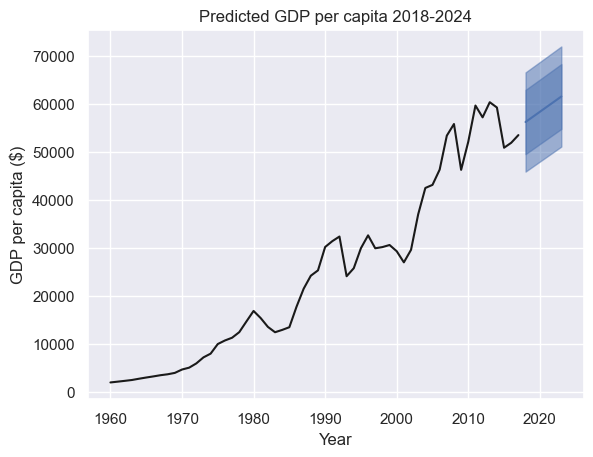

In [65]:
fig, ax = plt.subplots()
ax.plot(economy.Year, economy['GDP_per_capita'], color='k')
ax.plot(x.Year, pred80['mean'])
ax.fill_between(x.Year, pred95.obs_ci_lower, pred95.obs_ci_upper, color='C0', alpha=.5)
ax.fill_between(x.Year, pred80.obs_ci_lower, pred80.obs_ci_upper, color='C0', alpha=.5)
ax.set(title='Predicted GDP per capita 2018-2024', xlabel='Year', ylabel='GDP per capita ($)')
plt.show()